In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [16]:
#Reading the csv file into the dataframe
df = pd.read_csv("credit_analysis.csv")
df.head()

,CustomerID,Age,Gender,Income,LoanAmount,LoanTerm,CreditScore,EmploymentStatus,MaritalStatus,NumberOfDependents,ExistingLoansCount,LoanPurpose,Defaulted
0,1,56,Male,105680,4040,6,808,Self-employed,Single,4,1,Home,1
1,2,69,Male,22050,43422,48,625,Unemployed,Single,0,3,Business,1
2,3,46,Male,129996,27160,48,656,Employed,Married,2,1,Home,0
3,4,32,Male,53933,18633,6,690,Unemployed,Married,4,2,Car,1
4,5,60,Female,44951,30344,48,384,Unemployed,Single,2,0,Education,1


In [ ]:
# Checking for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 CustomerID            0
Age                   0
Gender                0
Income                0
LoanAmount            0
LoanTerm              0
CreditScore           0
EmploymentStatus      0
MaritalStatus         0
NumberOfDependents    0
ExistingLoansCount    0
LoanPurpose           0
Defaulted             0
dtype: int64


No missing values found in the data. So we move on to the next step.

In [ ]:
#Using Label Encoding for categorical data
categorical_cols = ['Gender', 'EmploymentStatus', 'MaritalStatus', 'LoanPurpose']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
#Dropping the unwanted columns
X = df.drop(columns=['CustomerID','Defaulted'])
Y = df['Defaulted']

In [ ]:
#Training the data using train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)

In [ ]:
#Choosing and fitting the model
#(I chose RandomForestClassifier for its strong performance with minimal tuning)
model = RandomForestClassifier(n_estimators=100, random_state=26)
model.fit(X_train, Y_train)

In [ ]:
#Predicting the results
Y_pred = model.predict(X_test)
print('Accuracy Score: ', accuracy_score(Y_test, Y_pred))
print('Classification Report: \n', classification_report(Y_test, Y_pred))
print('Confusion Matrix: \n', confusion_matrix(Y_test, Y_pred))

Accuracy Score:  0.775
Classification Report: 
               precision    recall  f1-score   support

           0       0.56      0.44      0.49        50
           1       0.83      0.89      0.86       150

    accuracy                           0.78       200
   macro avg       0.70      0.66      0.67       200
weighted avg       0.76      0.78      0.77       200

Confusion Matrix: 
 [[ 22  28]
 [ 17 133]]


Since the results did not meet expectations, let us apply hyperparameter tuning and SMOTE to improve the model's performance.

In [ ]:
#Performing hyperparameter tuning to find the best combination of parameters

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(rf, param_grid, n_iter=20, cv=5, scoring='f1', random_state=42, n_jobs=-1)
search.fit(X_train, Y_train)
print("Best Parameters:", search.best_params_)


Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None}


In [13]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to the training data to improve the accuracy
smote = SMOTE(random_state=42)
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)

# Training the model on resampled data after hyperparameter tuning
final_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=10,
    class_weight=None,
    random_state=42
)

final_model.fit(X_train_sm, Y_train_sm)

# Final evaluation
y_pred = final_model.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))


Accuracy: 0.8
Confusion Matrix:
 [[ 35  15]
 [ 25 125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.70      0.64        50
           1       0.89      0.83      0.86       150

    accuracy                           0.80       200
   macro avg       0.74      0.77      0.75       200
weighted avg       0.82      0.80      0.81       200



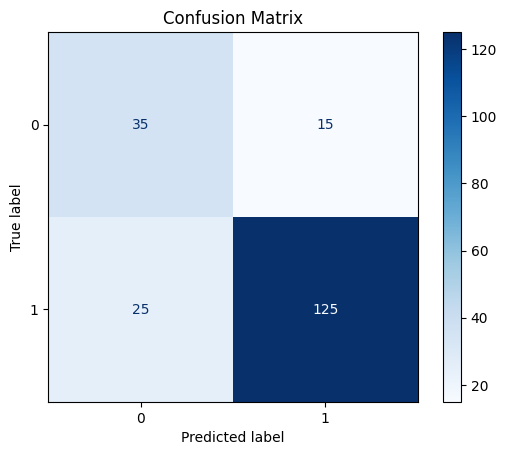

In [ ]:
# Creating the plot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppose y_test and y_pred are your true and predicted labels
cm = confusion_matrix(Y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()


Before SMOTE
Accuracy: 0.775

Class 0 Recall: 0.44

Confusion Matrix for class 0: [22 28] → Only 44% of class 0 were correctly predicted.

After SMOTE
Accuracy: 0.80 → Slight increase!

Class 0 Recall: 0.70 → Big jump!

Confusion Matrix for class 0: [35 15] → Now 70% of class 0 were correctly identified.

In [26]:
#Saving the model for future use
import joblib
joblib.dump(final_model, "credit_model.pkl")

['credit_model.pkl']